# DAMASK tutorial

- creating necessary inputs for damask
- defining the elastoplastic model(isotropic hardening) for tensile test
- runing the damask jobs

here more option is given to the user to select from damask python package itself.

Author: Yang Bai

Date  : 23.02.2022

Update: 01.08.2022

## Importing libraries and creatign Project

In [1]:
from pyiron_continuum import Project
from damask import Rotation # this will be used in material configuration

### create a 'project' to manage all the configurations for a tensile test

In [2]:
pr = Project('isotropic')
pr.remove_jobs(silently=True) # automatically delete the existing project folder

  0%|          | 0/1 [00:00<?, ?it/s]

### Creating the Damask job

In [3]:
job = pr.create.job.DAMASK('damask_job')

#### for a damask job, one needs:
- geometry information(i.e., the mesh)
- material configuration(material.yaml)
- boundary conditions(i.e., loading.yaml)

### For material configuration
#### for elastoplastic material

In [4]:
elasticity = pr.continuum.damask.Elasticity(type= 'Hooke', C_11= 106.75e9,
                                   C_12= 60.41e9, C_44=28.34e9)
plasticity = pr.continuum.damask.Plasticity(type='isotropic',dot_gamma_0=0.001,
                                            n=20.,xi_0=0.4e+6,
                                            xi_inf=0.6e+6,a=2.,
                                            h_0=2.e+6, # hardening modulus
                                            M=1.,h=1.,
                                            dilatation=True,output=['xi'])
# for the details of isotropic model, one is referred to https://doi.org/10.1016/j.scriptamat.2017.09.047

#### for material configuration, you need
- phase
- roation
- homogenization

In [5]:
grains = 4
grids = 16

phase = pr.continuum.damask.Phase(composition='Aluminum', lattice= 'cF',
                         output_list=['F', 'P', 'F_e', 'F_p', 'L_p', 'O'],
                         elasticity=elasticity,plasticity=plasticity)
rotation = pr.continuum.damask.Rotation(Rotation.from_random, grains)

homogenization = pr.continuum.damask.Homogenization(method='SX', 
                                                     parameters={'N_constituents': 1,
                                                                 "mechanical": {"type": "pass"}})

# now you can define your material.yaml configuration
material = pr.continuum.damask.Material([rotation],['Aluminum'], phase, homogenization)

# now you can save your material to your job
job.material = material

## For geometry information

In [6]:
grid = pr.continuum.damask.Grid.via_voronoi_tessellation(box_size=1.0e-5, grid_dim=grids, num_grains=grains)

# save the geometry information to your job
job.grid = grid 

## For boundary conditions (loading)

In [7]:
load_step =[{'mech_bc_dict':{'dot_F':[5e-5,0,0, 0,'x',0,  0,0,'x'],
                            'P':['x','x','x', 'x',0,'x',  'x','x',0]},
            'discretization':{'t': 10.,'N': 200},
            'additional': {'f_out': 5}
           }]
solver = job.list_solvers()[0] # choose the mechanis solver
job.loading = pr.continuum.damask.Loading(solver=solver, load_steps=load_step)

In [8]:
job.run() # running your job, if you want the parallelization you can modify your 'pyiron/damask/bin/run_damask_3.0.0.sh file'

The job damask_job was saved and received the ID: 16


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$\\varepsilon_x$$_x$', ylabel='$\\sigma_x$$_x$(Pa)'>)

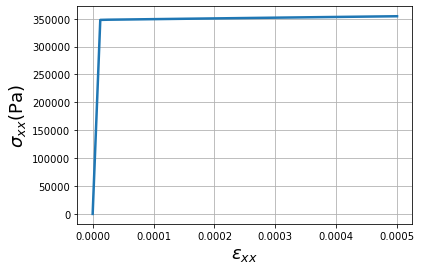

In [9]:
# plot the strain_xx vs stress_xx profile
job.plot_stress_strain(component='xx')

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$\\varepsilon_{vM}$', ylabel='$\\sigma_{vM}$ (Pa)'>)

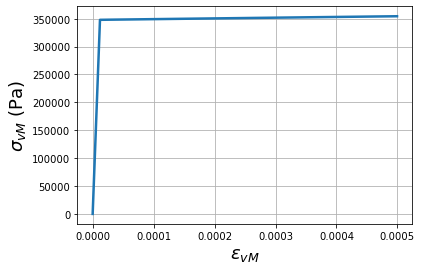

In [10]:
# plot the vonMises-strain vs vonMises-stress profile
job.plot_stress_strain(von_mises=True)

In [11]:
# job.writeresults2vtk() # you can also save all the field quantities to vtk files